# Metadata

```
Cours:   DS 5001
Module:  07 Lab
Topic:   PCA
Author:  R.C. Alvarado
Adapted by: Nicholas Keeley

Purpose: To implement PCA from scratch using eigendecomposition of the term covariance matrix and explore its application to Austen-Melville corpus
```

# References

This document was adapted off of a copy of the notebook "M07_01_PCA-REVISED"

# Set Up

In [124]:
norm_docs = True # L2 norming
center_by_mean = False 
center_by_variance = True # Not supposed to ... Exaggerates significance of rare words
n_terms = 1000 # Number of significant words; feature space
k = 6 # Number of components

In [125]:
data_home = "../data"
local_lib = '../lib'
data_prefix = 'novels'

In [126]:
## Adjusted OHCO for HW

OHCO = ['book_id','chap_id','para_num','sent_num','token_num']

In [127]:
import pandas as pd
import numpy as np
# from sklearn.decomposition import PCA
from scipy.linalg import norm, eigh

In [128]:
import plotly_express as px
import seaborn as sns; sns.set()

In [129]:
## Copy required homework library functions


def create_bow(CORPUS:pd.DataFrame, bag:list, item_type:str='term_str'):
    """
    Create a bag-of-words representation from a table tokens.
    Arguments:
        CORPUS (pd.DataFrame): a DataFrame with an OHCO index and ``['term_str','max_pos']`` in columns.
        bag (list): a slice of the OHCO index identifying the bag level, e.g. ``['book_id', 'chap_id']`` for chapter bags.
        item_type (string): the name of the column containing the normalized token string.
    Returns:
        A DataFrame with an the bag-level OHCO and ``['n']`` column for number of tokens in each bag.
    """
    BOW = CORPUS.groupby(bag+[item_type])[item_type].count().to_frame('n')
    return BOW

def get_tfidf(BOW:pd.DataFrame, tf_method:str='max', idf_method:str='standard'):
    """
    Get a TFIDF-weighted document-term matrix from a bag-of-words table.
    Arguments:
        BOW (pd.DataFrame): A DataFrame produced by ``create_bow()``
        tf_method (string): The term frequency count method. Options: sum, max, log, raw, and bool. Defaults to max.
        idf_method (strings): The inversre document frequency count method. Options: standard, textbook, sklearn, sklearn_smooth. Defaults to standard.
    Returns:
        TFIDF (pd.DataFrame): A DataFrame with an unnormalized, zero-filled document-term matrix of TFIDF weights.
        DFIDF (pd.DataFrame): A Series with a vocabulary as index and DFIDF as value.
    """
            
    DTCM = BOW.n.unstack() # Create Doc-Term Count Matrix
    
    if tf_method == 'sum':
        TF = (DTCM.T / DTCM.T.sum()).T
    elif tf_method == 'max':
        TF = (DTCM.T / DTCM.T.max()).T
    elif tf_method == 'log':
        TF = (np.log2(DTCM.T + 1)).T
    elif tf_method == 'raw':
        TF = DTCM
    elif tf_method == 'bool':
        TF = DTCM.astype('bool').astype('int')
    else:
        raise ValueError(f"TF method {tf_method} not found.")

    DF = DTCM.count() # Assumes NULLs 
    N_docs = len(DTCM)
    
    if idf_method == 'standard':
        IDF = np.log2(N_docs/DF) # This what the students were asked to use
    elif idf_method == 'textbook':
        IDF = np.log2(N_docs/(DF + 1))
    elif idf_method == 'sklearn':
        IDF = np.log2(N_docs/DF) + 1
    elif idf_method == 'sklearn_smooth':
        IDF = np.log2((N_docs + 1)/(DF + 1)) + 1
    else:
        raise ValueError(f"DF method {df_method} not found.")
    
    TFIDF = TF * IDF
    TFIDF = TFIDF.fillna(0)

    DFIDF = DF * IDF

    return TFIDF, DFIDF

def get_pca(TFIDF, 
            k:int=10, 
            norm_docs:bool=True, 
            center_by_mean:bool=True, 
            center_by_variance:bool=False):
    """
    Get principal components and loadings from a TFIDF matrix. Typically, this will be one with a
    a reduced feature spacing, i.e. of the top ``n`` significant terms.
    Arguments:
        k (int): The number of components to return. Defaults to 10.
        norm_docs (bool): Whether to apply L2 normalization or not. Defaults to True.
        center_by_mean (bool): Whether to center term vectors by mean. Defaults to True.
        center_by_variance (bool): Whether to center term vectors by standard deviation. Defaults to False.
    Returns:
        LOADINGS (pd.DataFrame): A DataFrame of terms by principal components. 
        DCM (pd.DataFrame): A DataFrame of documents by principal components.
        COMPINF (pd.DataFrame): A DataFrame of information about each component.
    """
    
    if TFIDF.isna().sum().sum():
        TFIDF = TFIDF.fillna(0)
    
    if norm_docs:
        TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0)
    
    if center_by_mean:
        TFIDF = TFIDF - TFIDF.mean()
        
    if center_by_variance:
        TFIDF = TFIDF / TFIDF.std()        

    COV = TFIDF.cov()

    eig_vals, eig_vecs = eigh(COV)
    EIG_VEC = pd.DataFrame(eig_vecs, index=COV.index, columns=COV.index)
    EIG_VAL = pd.DataFrame(eig_vals, index=COV.index, columns=['eig_val'])
    EIG_VAL.index.name = 'term_str'
        
    EIG_IDX = EIG_VAL.eig_val.sort_values(ascending=False).head(k)
    
    COMPS = EIG_VEC[EIG_IDX.index].T
    COMPS.index = [i for i in range(COMPS.shape[0])]
    COMPS.index.name = 'pc_id'

    LOADINGS = COMPS.T

    DCM = TFIDF.dot(LOADINGS)
    
    COMPINF = pd.DataFrame(index=COMPS.index)

    for i in range(k):
        for j in [0, 1]:
            top_terms = ' '.join(LOADINGS.sort_values(i, ascending=bool(j)).head(5).index.to_list())
            COMPINF.loc[i, j] = top_terms
    COMPINF = COMPINF.rename(columns={0:'pos', 1:'neg'})
    
    COMPINF['eig_val'] = EIG_IDX.reset_index(drop=True).to_frame()
    COMPINF['exp_var'] = COMPINF.eig_val / COMPINF.eig_val.sum()
    
    return LOADINGS, DCM, COMPINF
  

# Prepare the Data

## Read in files

In [130]:
CORPUS = pd.read_csv(f"{data_home}/novels/{data_prefix}-CORPUS.csv").set_index(OHCO+['term_str'])
#VOCAB = pd.read_csv(f'{data_home}/novels/{data_prefix}-VOCAB2.csv').set_index('term_str')
LIB = pd.read_csv(f'{data_home}/novels/{data_prefix}-LIB.csv').set_index('book_id')

## `LIB`

In [131]:
#LIB.title = LIB.title.apply(lambda x: x[:20])
#LIB['label'] = LIB.apply(lambda x: f"{x.author_id.split(',')[0]}–{x.title[:10]}–{x.genre[0].upper()}–{x.name}", 1)

In [132]:
LIB.head(15)

genre_id author_id
book_id                           
secretadversary        d  christie
styles                 d  christie
moonstone              d   collins
adventures             d     doyle
baskervilles           d     doyle
scarlet                d     doyle
signoffour             d     doyle
marieroget             d       poe
ruemorgue              d       poe
northangerabbey        g    austen
christmascarole        g   dickens
monk                   g     lewis
pitandpendulum         g       poe
reddeath               g       poe
usher                  g       poe

In [133]:
CORPUS.head()

pos
book_id         chap_id para_num sent_num token_num term_str        
secretadversary 1       0        1        0         the           DT
                                          1         young        NNP
                                          2         adventurers  NNP
                                          3         ltd          NNP
                        1        0        0         tommy         JJ

## Step 2: Create VOCAB w/ max_pos

In [134]:
## Step 2: Create VOCAB with max_pos

VOCAB=CORPUS.reset_index()

In [135]:
VOCAB_clean=VOCAB.term_str.value_counts().to_frame("n").reset_index().rename(columns={"index":"term_str"})
max_pos=VOCAB.groupby("term_str").agg({"pos":"max"}).sort_values(by="term_str")
#VOCAB_clean["max_pos"]=max_pos
VOCAB_clean=VOCAB_clean.set_index("term_str")
#VOCAB_clean.sort_values(by="term_str")

In [136]:
VOCAB_clean=pd.merge(VOCAB_clean, max_pos, on="term_str")
VOCAB_clean=VOCAB_clean.sort_values(by="term_str")

In [137]:
VOCAB_clean.head()

n  pos
term_str             
a          28533  VBZ
aback          9   RB
abaft          2  VBZ
abandon       44  VBP
abandoned     68  VBN

## Step 3: TFIDF and DFIDF Tables

In [138]:
## Preprocessing

bag = ['book_id', 'chap_id']
tf_method = 'max'
idf_method = 'standard'

In [139]:
CORPUS_tab=CORPUS.reset_index()
CORPUS_tab.head()

book_id  chap_id  para_num  sent_num  token_num     term_str  pos
0  secretadversary        1         0         1          0          the   DT
1  secretadversary        1         0         1          1        young  NNP
2  secretadversary        1         0         1          2  adventurers  NNP
3  secretadversary        1         0         1          3          ltd  NNP
4  secretadversary        1         1         0          0        tommy   JJ

In [140]:
## Compute BOW table

BOW=create_bow(CORPUS_tab, bag)
#BOW.query("book_id != 'adventures'")

In [141]:
## Compute TFIDF table

TFIDF, DFIDF=get_tfidf(BOW, tf_method, idf_method)
DFIDF.head()
LIB.head()

genre_id author_id
book_id                           
secretadversary        d  christie
styles                 d  christie
moonstone              d   collins
adventures             d     doyle
baskervilles           d     doyle

## Step 4: Create DOC table

In [142]:
## DOC table

lib_cols = LIB.columns
DOC = pd.DataFrame(index=TFIDF.index)
DOC = DOC.join(LIB[lib_cols], on='book_id')
DOC
DOC['label'] = DOC.apply(lambda x: "{}-{}-{}-{}".format(x.genre_id, x.author_id, x.name[0], x.name[1]), 1)
DOC

genre_id  author_id                   label
book_id    chap_id                                            
adventures 1              d      doyle    d-doyle-adventures-1
           2              d      doyle    d-doyle-adventures-2
           3              d      doyle    d-doyle-adventures-3
           4              d      doyle    d-doyle-adventures-4
           5              d      doyle    d-doyle-adventures-5
...                     ...        ...                     ...
udolpho    54             g  radcliffe  g-radcliffe-udolpho-54
           55             g  radcliffe  g-radcliffe-udolpho-55
           56             g  radcliffe  g-radcliffe-udolpho-56
           57             g  radcliffe  g-radcliffe-udolpho-57
usher      1              g        poe           g-poe-usher-1

[320 rows x 3 columns]

## Step 5: Reduced TFIDF

In [143]:
## Top 1000 nouns NNS and NN

NOUNS=pd.DataFrame(DFIDF).rename(columns={0:"count"})
VOCAB_clean.head()
VOCAB_clean=VOCAB_clean.rename(columns={"pos":"max_pos"})
VOCAB_nouns=VOCAB_clean.query("max_pos == 'NN' | max_pos == 'NNS'")
NOUNS=NOUNS.join(VOCAB_nouns, on="term_str").dropna(axis=0)
NOUNS=NOUNS.drop("n", axis=1)
NOUNS=NOUNS.sort_values(by="count",ascending=False)[0:1000]
nouns_filter=NOUNS.reset_index().term_str
nouns_filter

## Reduce TFIDF

TFIDF_clean=TFIDF[nouns_filter]
TFIDF_clean

term_str                book       mrs   husband     party   passage  \
book_id    chap_id                                                     
adventures 1        0.003282  0.002964  0.010631  0.000000  0.007271   
           2        0.000000  0.000000  0.000000  0.003421  0.010529   
           3        0.004159  0.003755  0.008980  0.000000  0.004607   
           4        0.000000  0.000000  0.002988  0.005975  0.000000   
           5        0.006190  0.000000  0.000000  0.000000  0.003428   
...                      ...       ...       ...       ...       ...   
udolpho    54       0.000000  0.000000  0.000000  0.004215  0.000000   
           55       0.000000  0.000000  0.010197  0.005098  0.000000   
           56       0.000000  0.000000  0.000000  0.008589  0.000000   
           57       0.000000  0.000000  0.000000  0.000000  0.000000   
usher      1        0.005219  0.000000  0.000000  0.000000  0.000000   

term_str            information    months     usual   moments  considerable  \
book_id    chap_id                                                            
adventures 1           0.007590  0.003828  0.002561  0.000000      0.000000   
           2           0.000000  0.011086  0.002472  0.002450      0.019806   
           3           0.000000  0.004850  0.003244  0.000000      0.005199   
           4           0.003200  0.003227  0.004318  0.000000      0.017297   
           5           0.000000  0.010828  0.002414  0.000000      0.003869   
...                         ...       ...       ...       ...           ...   
udolpho    54          0.004514  0.004553  0.003045  0.015095      0.000000   
           55          0.000000  0.011014  0.000000  0.003652      0.005903   
           56          0.000000  0.000000  0.000000  0.018458      0.009946   
           57          0.000000  0.019851  0.000000  0.000000      0.000000   
usher      1           0.000000  0.000000  0.004071  0.006054      0.000000   

term_str            ...    device  recital  inattentive      jury  delirious  \
book_id    chap_id  ...                                                        
adventures 1        ...  0.000000      0.0          0.0  0.000000   0.000000   
           2        ...  0.000000      0.0          0.0  0.000000   0.000000   
           3        ...  0.000000      0.0          0.0  0.000000   0.000000   
           4        ...  0.000000      0.0          0.0  0.027576   0.018384   
           5        ...  0.000000      0.0          0.0  0.041120   0.000000   
...                 ...       ...      ...          ...       ...        ...   
udolpho    54       ...  0.000000      0.0          0.0  0.000000   0.000000   
           55       ...  0.000000      0.0          0.0  0.000000   0.000000   
           56       ...  0.000000      0.0          0.0  0.000000   0.000000   
           57       ...  0.000000      0.0          0.0  0.000000   0.000000   
usher      1        ...  0.008668      0.0          0.0  0.000000   0.000000   

term_str            wiser  removal   bottles   decease  repulsive  
book_id    chap_id                                                 
adventures 1          0.0      0.0  0.000000  0.000000        0.0  
           2          0.0      0.0  0.000000  0.000000        0.0  
           3          0.0      0.0  0.013814  0.000000        0.0  
           4          0.0      0.0  0.000000  0.000000        0.0  
           5          0.0      0.0  0.000000  0.000000        0.0  
...                   ...      ...       ...       ...        ...  
udolpho    54         0.0      0.0  0.000000  0.000000        0.0  
           55         0.0      0.0  0.000000  0.015685        0.0  
           56         0.0      0.0  0.000000  0.000000        0.0  
           57         0.0      0.0  0.000000  0.056541        0.0  
usher      1          0.0      0.0  0.000000  0.008668        0.0  

[320 rows x 1000 columns]

## Step 6: Get PCA

In [144]:
## Get PCA

LOADINGS, DCM, COMPINF =get_pca(TFIDF_clean, k, 
            norm_docs, 
            center_by_mean, 
            center_by_variance)


## Step 7: Visualize

In [145]:
DOC_join=DOC.join(DCM)
DCM



pc_id                      0         1          2         3         4  \
book_id    chap_id                                                      
adventures 1       -2.754052 -0.998068  -4.204056 -4.331046  3.753579   
           2       -4.525687 -3.850553  -8.381489 -6.601852  5.192790   
           3       -5.664394 -4.761883  -8.929753 -8.884747  7.220263   
           4       -3.345650 -3.126624  -7.034680 -5.212626  7.972935   
           5       -3.205481 -2.319461  -8.802650 -4.528118  6.765793   
...                      ...       ...        ...       ...       ...   
udolpho    54       7.397811  3.557766  -3.624006 -4.177188  1.781035   
           55       9.274702  4.383681  -4.904579 -4.579879  0.538041   
           56       6.433087 -2.268592   1.020790 -2.556086  1.013602   
           57       3.242908  0.746783   2.043994 -1.418145 -2.871936   
usher      1        5.260694 -5.713445 -16.411916 -0.084559  0.566302   

pc_id                      5  
book_id    chap_id            
adventures 1       -0.275990  
           2       -2.124804  
           3       -3.122559  
           4       -2.122137  
           5       -4.731985  
...                      ...  
udolpho    54      -2.405141  
           55       0.105099  
           56      -0.232994  
           57      -2.912032  
usher      1       -5.178595  

[320 rows x 6 columns]

In [146]:
px.scatter(DOC_join, 0, 1, 
           color='author_id', symbol='genre_id', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

In [147]:
LOADINGS.sort_values(by=1, ascending=False)

pc_id               0         1         2         3         4         5
term_str                                                               
relations    0.041486  0.073469 -0.033895 -0.010928  0.018467  0.011284
faults       0.022545  0.072194 -0.004814 -0.014957  0.026353  0.005212
objection   -0.011580  0.069556  0.031029 -0.026489  0.045199 -0.001413
approbation  0.040509  0.066854  0.012468 -0.006126 -0.007949 -0.053440
lords        0.030881  0.064788  0.014886 -0.015050 -0.021392 -0.097144
...               ...       ...       ...       ...       ...       ...
margin       0.063487 -0.118980  0.033640 -0.020770  0.033384  0.060045
herds        0.053280 -0.119585  0.034359  0.030494  0.054096  0.044183
foliage      0.085574 -0.126366  0.059125 -0.024305  0.049008  0.047017
scenery      0.089009 -0.132259  0.057938  0.000784  0.054325  0.029262
cliffs       0.067248 -0.138223  0.055722  0.004016  0.025215  0.057637

[1000 rows x 6 columns]

In [148]:
px.bar(DOC_join.groupby('author_id')[2].mean(), width=400, height=500)

**Add metadata on genre and mood**

In [149]:
abs(DOC_join.groupby('author_id')[0].mean())

author_id
austen        2.417082
christie      2.377540
collins       0.488809
dickens       0.267075
doyle         2.477514
lewis        11.598136
poe           2.097468
radcliffe     7.932623
reeve         5.295630
shelley       4.774131
stoker        1.292214
walpole       7.231553
Name: 0, dtype: float64

In [150]:
DOC_join.groupby('author_id')[3].min()

author_id
austen      -5.290484
christie    -5.950114
collins     -4.790234
dickens     -1.742145
doyle       -8.884747
lewis       -4.716729
poe         -6.414099
radcliffe   -9.524139
reeve       -3.531991
shelley      0.176978
stoker      -2.600621
walpole     -2.778631
Name: 3, dtype: float64

In [151]:
meta_csv = """
105, domestic, romance
121, gothic, satire
141, domestic, satire
158, domestic, romance
161, domestic, romance
946, domestic, romance
1212, domestic, satire
1342, domestic, romance
1900, travel, adventure
2701, sea, adventure
4045, travel, adventure
8118, sea, adventure
10712, sea, critical
13720, sea, adventure
13721, sea, adventure
15422, historical, adventure
21816, travel, satire
34970, gothic, psychological
""".split('\n')[1:-1]
meta = pd.DataFrame([line.split(', ') for line in meta_csv], columns=['book_id','genre', 'mood'])
meta.book_id = meta.book_id.astype('int')
meta = meta.set_index('book_id')

In [9]:
LIB = pd.concat([LIB, meta], axis=1)

In [10]:
LIB['label'] = LIB.apply(lambda x: f"{x.author.split(',')[0]}–{x.title[:10]}–{x.genre[0].upper()}–{x.name}", 1)

In [11]:
LIB

source_file_path            author  \
book_id                                                                        
105      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
121      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
141      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
158      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
161      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
946      ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1212     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1342     ../data/gutenberg/austen-melville-set/AUSTEN_J...      AUSTEN, JANE   
1900     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
2701     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
4045     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
8118     ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
10712    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13720    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
13721    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
15422    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
21816    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   
34970    ../data/gutenberg/austen-melville-set/MELVILLE...  MELVILLE, HERMAN   

                        title                       chap_regex  book_len  \
book_id                                                                    
105                PERSUASION                  ^Chapter\s+\d+$     83624   
121          NORTHANGER ABBEY                  ^CHAPTER\s+\d+$     77601   
141            MANSFIELD PARK            ^CHAPTER\s+[IVXLCM]+$    160378   
158                      EMMA      ^\s*CHAPTER\s+[IVXLCM]+\s*$    160926   
161      SENSE AND SENSIBILIT                  ^CHAPTER\s+\d+$    119873   
946                LADY SUSAN                ^\s*[IVXLCM]+\s*$     23116   
1212     LOVE AND FREINDSHIP              ^\s*LETTER .* to .*$     33265   
1342      PRIDE AND PREJUDICE                  ^Chapter\s+\d+$    122126   
1900     TYPEE A ROMANCE OF T                        ^CHAPTER     108021   
2701     MOBY DICK OR THE WHA  ^(?:ETYMOLOGY|EXTRACTS|CHAPTER)    215504   
4045     OMOO ADVENTURES IN T    ^\s*CHAPTER\s+[IVXLCM]+\.\s*$    102352   
8118     REDBURN HIS FIRST VO              ^\s*[IVXLCM]+\. .*$    119243   
10712    WHITE JACKET OR THE        ^CHAPTER\s+[IVXLCM]+\.\s*$    143310   
13720    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$     96878   
13721    MARDI AND A VOYAGE T      ^\s*CHAPTER\s+[IVXLCM]+\s*$    102092   
15422    ISRAEL POTTER HIS FI        ^\s*CHAPTER\s+[IVXLCM]+\.     65516   
21816    THE CONFIDENCE MAN H         ^CHAPTER\s+[IVXLCM]+\.?$     95315   
34970    PIERRE OR THE AMBIGU              ^\s*[IVXLCM]+\.\s*$    155056   

         n_chaps       genre           mood                        label  
book_id                                                                   
105           24    domestic        romance      AUSTEN–PERSUASION–D–105  
121           31      gothic         satire      AUSTEN–NORTHANGER–G–121  
141           48    domestic         satire      AUSTEN–MANSFIELD –D–141  
158           55    domestic        romance            AUSTEN–EMMA–D–158  
161           50    domestic        romance      AUSTEN–SENSE AND –D–161  
946           41    domestic        romance      AUSTEN–LADY SUSAN–D–946  
1212          24    domestic         satire     AUSTEN–LOVE AND F–D–1212  
1342          61    domestic        romance     AUSTEN–PRIDE AND –D–1342  
1900          34      travel      adventure   MELVILLE–TYPEE A RO–T–1900  
2701         138         sea      adventure   MELVILLE–MOBY DICK –S–2701  
4045          82    

## `VOCAB`

In [12]:
SIGS = VOCAB.sort_values('dfidf', ascending=False).head(n_terms).index

In [13]:
SIGS

Index(['home', 'cried', 'certain', 'why', 'whether', 'looking', 'set',
       'general', 'manner', 'felt',
       ...
       'boys', 'seat', 'owing', 'seas', 'solitary', 'presented', 'trust',
       'melancholy', 'absolutely', 'yards'],
      dtype='object', name='term_str', length=1000)

## `TFIDF`

In [14]:
TFIDF = BOW.tfidf.unstack(fill_value=0)[SIGS]

In [15]:
TFIDF

term_str             home     cried   certain       why   whether   looking  \
book_id chap_id                                                               
105     1        0.000331  0.000000  0.000167  0.000000  0.000000  0.000000   
        2        0.000659  0.000000  0.000000  0.000000  0.000000  0.000224   
        3        0.000459  0.000305  0.000154  0.000000  0.000155  0.000312   
        4        0.000481  0.000000  0.000243  0.000000  0.000000  0.000000   
        5        0.000261  0.000000  0.000000  0.000000  0.000000  0.000266   
...                   ...       ...       ...       ...       ...       ...   
34970   110      0.000000  0.000658  0.000000  0.000667  0.000000  0.000000   
        111      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        112      0.000658  0.000000  0.000000  0.000000  0.000000  0.000000   
        113      0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
        114      0.000000  0.001342  0.000000  0.000000  0.000000  0.000000   

term_str              set   general    manner      felt  ...      boys  \
book_id chap_id                                          ...             
105     1        0.000162  0.000000  0.000000  0.000676  ...  0.000000   
        2        0.000000  0.000000  0.000225  0.000675  ...  0.000000   
        3        0.000450  0.000000  0.000000  0.000000  ...  0.000000   
        4        0.000000  0.000492  0.000246  0.000246  ...  0.000000   
        5        0.000513  0.000000  0.000535  0.000401  ...  0.000296   
...                   ...       ...       ...       ...  ...       ...   
34970   110      0.000000  0.000000  0.000000  0.000675  ...  0.000000   
        111      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        112      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        113      0.000000  0.000000  0.000000  0.000000  ...  0.000000   
        114      0.000000  0.000000  0.000000  0.000000  ...  0.001525   

term_str             seat     owing  seas  solitary  presented     trust  \
book_id chap_id                                                            
105     1        0.000375  0.000000   0.0  0.000000   0.000376  0.000000   
        2        0.000000  0.000000   0.0  0.000000   0.000000  0.000000   
        3        0.000000  0.000000   0.0  0.000000   0.000000  0.000000   
        4        0.000000  0.000000   0.0  0.000000   0.000000  0.000547   
        5        0.000296  0.000296   0.0  0.000000   0.000000  0.000000   
...                   ...       ...   ...       ...        ...       ...   
34970   110      0.000000  0.000000   0.0  0.000000   0.000000  0.000000   
        111      0.000000  0.000000   0.0  0.000000   0.000000  0.000000   
        112      0.000000  0.000000   0.0  0.000000   0.000000  0.000000   
        113      0.000000  0.000000   0.0  0.002597   0.000000  0.000000   
        114      0.000000  0.000000   0.0  0.000000   0.000000  0.000000   

term_str         melancholy  absolutely  yards  
book_id chap_id                                 
105     1          0.000000    0.000000    0.0  
        2          0.000000    0.000000    0.0  
        3          0.000000    0.000000    0.0  
        4          0.000000    0.000000    0.0  
        5          0.000297    0.000297    0.0  
...                     ...         ...    ...  
34970   110        0.000000    0.000000    0.0  
        111        0.000000    0.000000    0.0  
        112        0.000000    0.000000    0.0  
        113        0.000000    0.000000    0.0  
        114        0.000000    0.000000    0.0  

[1184 rows x 1000 columns]

## `DOC`

In [16]:
lib_cols = "author title genre mood".split()
DOC = pd.DataFrame(index=TFIDF.index)
DOC = DOC.join(LIB[lib_cols], on='book_id')

In [17]:
DOC['label'] = DOC.apply(lambda x: "{}-{}-{}".format(x.author, x.title, x.name[1]), 1)
DOC['mean_tfidf'] = TFIDF.mean(1)
DOC['n_tokens'] = BOW.groupby(['book_id','chap_id']).n.sum()

In [18]:
DOC

author                 title     genre  \
book_id chap_id                                                     
105     1            AUSTEN, JANE            PERSUASION  domestic   
        2            AUSTEN, JANE            PERSUASION  domestic   
        3            AUSTEN, JANE            PERSUASION  domestic   
        4            AUSTEN, JANE            PERSUASION  domestic   
        5            AUSTEN, JANE            PERSUASION  domestic   
...                           ...                   ...       ...   
34970   110      MELVILLE, HERMAN  PIERRE OR THE AMBIGU    gothic   
        111      MELVILLE, HERMAN  PIERRE OR THE AMBIGU    gothic   
        112      MELVILLE, HERMAN  PIERRE OR THE AMBIGU    gothic   
        113      MELVILLE, HERMAN  PIERRE OR THE AMBIGU    gothic   
        114      MELVILLE, HERMAN  PIERRE OR THE AMBIGU    gothic   

                          mood                                      label  \
book_id chap_id                                                             
105     1              romance                  AUSTEN, JANE-PERSUASION-1   
        2              romance                  AUSTEN, JANE-PERSUASION-2   
        3              romance                  AUSTEN, JANE-PERSUASION-3   
        4              romance                  AUSTEN, JANE-PERSUASION-4   
        5              romance                  AUSTEN, JANE-PERSUASION-5   
...                        ...                                        ...   
34970   110      psychological  MELVILLE, HERMAN-PIERRE OR THE AMBIGU-110   
        111      psychological  MELVILLE, HERMAN-PIERRE OR THE AMBIGU-111   
        112      psychological  MELVILLE, HERMAN-PIERRE OR THE AMBIGU-112   
        113      psychological  MELVILLE, HERMAN-PIERRE OR THE AMBIGU-113   
        114      psychological  MELVILLE, HERMAN-PIERRE OR THE AMBIGU-114   

                 mean_tfidf  n_tokens  
book_id chap_id                        
105     1          0.000145      2625  
        2          0.000153      1974  
        3          0.000155      2837  
        4          0.000148      1805  
        5          0.000153      3322  
...                     ...       ...  
34970   110        0.000146       658  
        111        0.000128      1084  
        112        0.000120       659  
        113        0.000133       380  
        114        0.000155       645  

[1184 rows x 7 columns]

# Compute PCA

## Normalize doc vector lengths

We use TFIDF normalization, which scales documents by their pythagorean (Euclidean) length.

In [19]:
if norm_docs:
    print("L2 norming")
    TFIDF = TFIDF.apply(lambda x: x / norm(x), 1).fillna(0) # Euclidean norming

L2 norming


## Center term vectors

Note that we are taking the column-wise means -- the means for the _term_ vectors. Also, we do this *after* normalizing the documents.

**NOTE:** Some argue that centering alters the cosine angles.

In [20]:
if center_by_mean:
    print("Centering by mean")
    TFIDF = TFIDF - TFIDF.mean()

## Normalize term vector variance

We do **not** normalize variance, which we would normally do, such as with data containing divergent units of measure. \
This is because to do so would exaggerate the importance of rare words (see Ng, 2008: 6m40s–8m00s).

In [21]:
if center_by_variance:
    print("Centering by variance")
    TFIDF = TFIDF / TFIDF.std()

## Compute Covariance Matrix

$n = |X| = |Y|$

$Cov(X,Y) = \dfrac{\sum_{i=1}^{n} (x_i - \mu_X) (y_i - \mu_Y)}{n - 1} = \dfrac{XY}{n-1}$

In [22]:
COV = TFIDF.cov()

In [23]:
# COV

In [24]:
COV.stack().sort_values().loc['whale']

term_str
she     -0.003385
her     -0.003164
mr      -0.001576
mrs     -0.001570
miss    -0.001237
           ...   
sea      0.001337
fish     0.001734
ship     0.001809
boat     0.002665
whale    0.017270
Length: 1000, dtype: float64

## Decompose the Matrix

There a at least three options to choose from. We go with SciPy's Hermitian Eigendecomposition \
method `eigh()`, since our covarience matrix is symmetric.

Return values (from the docs):

>`w(…, M) ndarray`\
The eigenvalues in ascending order, each repeated according to its multiplicity.

> `v{(…, M, M) ndarray, (…, M, M) matrix}`\
The column v[:, i] is the normalized eigenvector corresponding to the eigenvalue w[i]. Will return a matrix object if a is a matrix object.

- Eigenvalues are returned in ascending order.
- Eigenvectors are returned with columns sorted in the order of the eigenvalues.

In [25]:
from scipy.linalg import eigh

In [26]:
w, v = eigh(COV, subset_by_index=(len(COV)-k,len(COV)-1))

In [27]:
pc_ids = list(reversed([i for i in range(k)]))

In [28]:
C = pd.DataFrame(w, columns=['eig_val'])
C.index = pc_ids
C = C.sort_index()
C.index.name = 'pc_id'
C['exp_var'] = C.eig_val / C.eig_val.sum()

In [29]:
C

eig_val   exp_var
pc_id                    
0      0.075857  0.467892
1      0.024790  0.152908
2      0.019159  0.118177
3      0.016518  0.101884
4      0.013461  0.083031
5      0.012339  0.076109

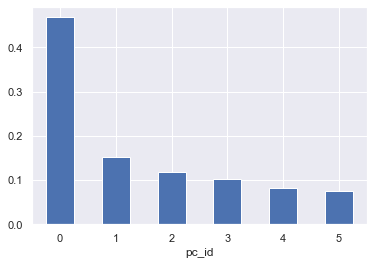

In [30]:
C.exp_var.plot.bar(rot=0);

In [31]:
L = pd.DataFrame(v, index=COV.index)
L.columns = pc_ids
L = L.T.sort_index().T
L.columns.name = 'pc_id'

In [32]:
# L[2].sort_values()

In [33]:
L.sample(20).style.background_gradient(cmap='GnBu', high=.5)

In [34]:
DCM = TFIDF.dot(L)

In [35]:
DCM.sample(20).style.background_gradient(cmap='GnBu', high=.5)

## Extract Poles

In [36]:
top_n = 6 # Number of top words for each pole
for i in range(k):
    for j, pole in enumerate(['neg','pos']):
        top_terms = ' '.join(L.sort_values(i, ascending=bool(j)).head(top_n).index.to_list())
        C.loc[i, pole] = top_terms

In [37]:
C

eig_val   exp_var                            neg  \
pc_id                                                      
0      0.075857  0.467892    whale sea ship deck ye thou   
1      0.024790  0.152908        thou thee thy ye art oh   
2      0.019159  0.118177   lord our war island king old   
3      0.016518  0.101884  thou thee captain thy her she   
4      0.013461  0.083031  her she island our trees king   
5      0.012339  0.076109  lord whale said king ye cried   

                                          pos  
pc_id                                          
0                 she her mr mrs miss herself  
1        captain ship deck sailors mate ships  
2                whale boat fish she her line  
3      lord whale king your nature confidence  
4                 sir mr dont captain your ye  
5          deck officers war captain her lady

# DCM Scatterplots

## PC 0 and 1

In [38]:
try:
    DOC = DOC.join(DCM)
except:
    pass

In [39]:
# DOC

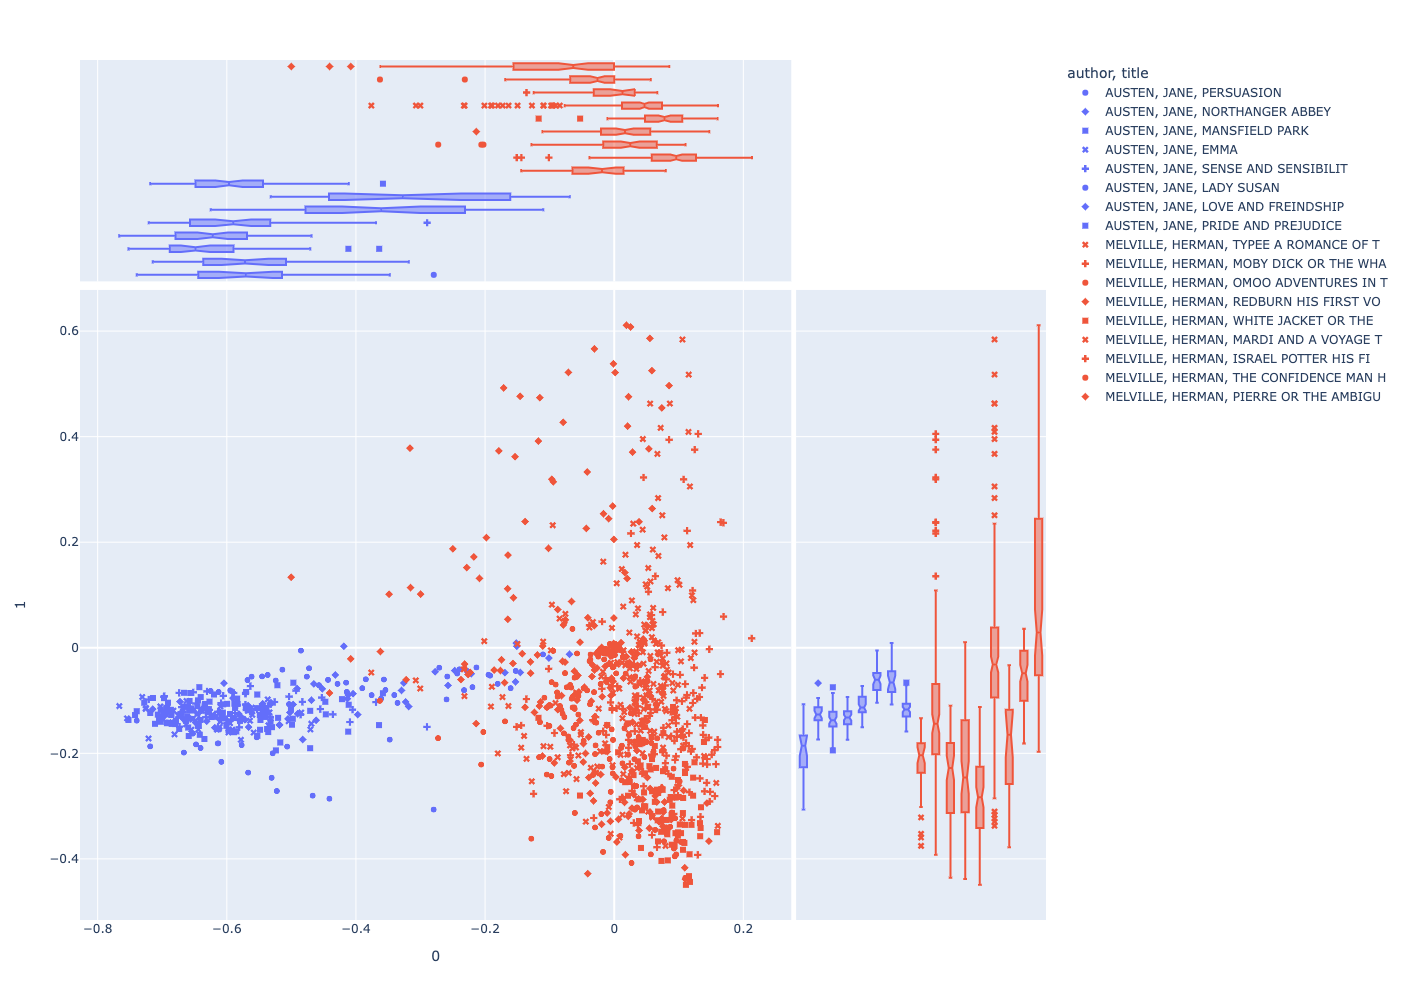

In [40]:
px.scatter(DOC, 0, 1, 
           color='author', symbol='title', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

In [41]:
C.loc[[0,1]]

eig_val   exp_var                          neg  \
pc_id                                                    
0      0.075857  0.467892  whale sea ship deck ye thou   
1      0.024790  0.152908      thou thee thy ye art oh   

                                        pos  
pc_id                                        
0               she her mr mrs miss herself  
1      captain ship deck sailors mate ships

## PC 2 and 3

In [42]:
# DOC

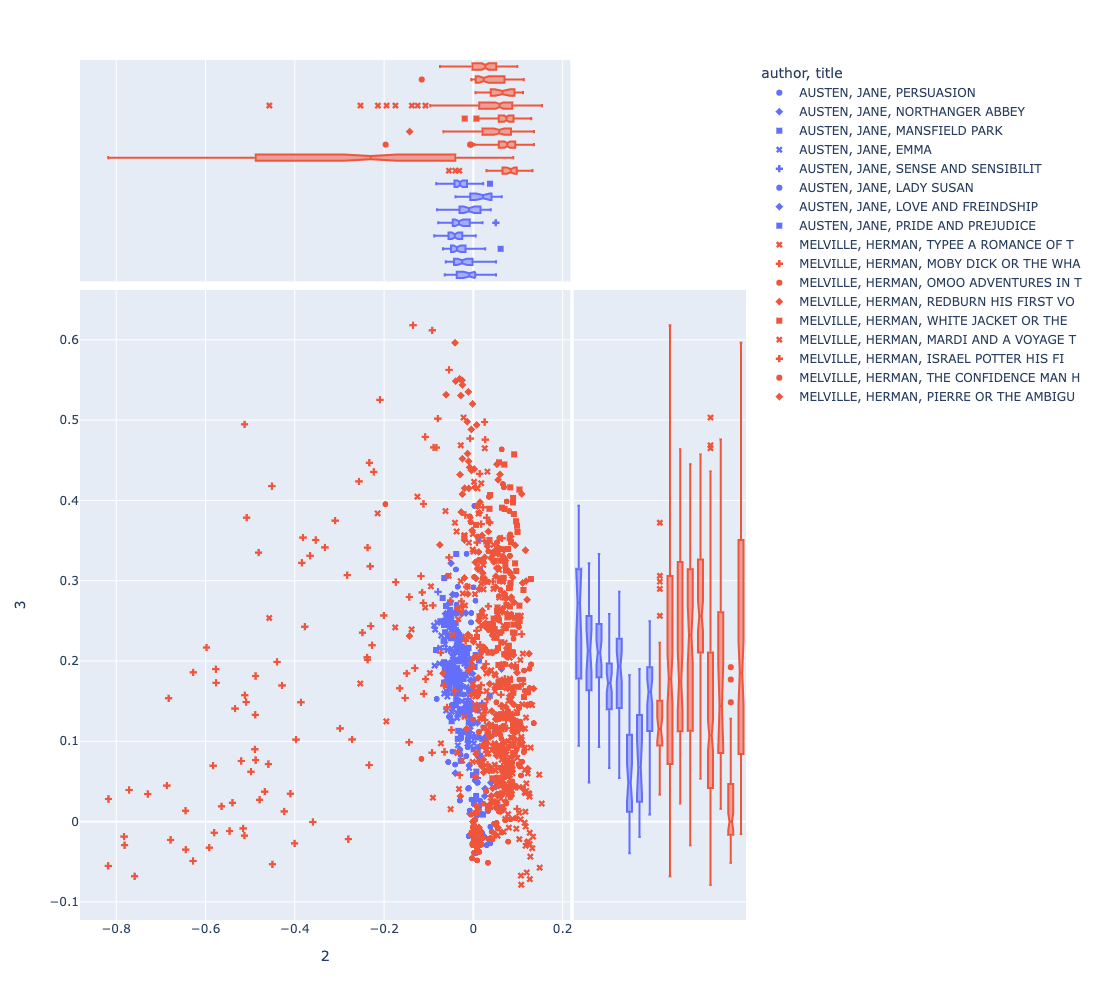

In [43]:
px.scatter(DOC, 2, 3, 
           color='author', symbol='title', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

In [44]:
C.loc[[2,3]]

eig_val   exp_var                            neg  \
pc_id                                                      
2      0.019159  0.118177   lord our war island king old   
3      0.016518  0.101884  thou thee captain thy her she   

                                          pos  
pc_id                                          
2                whale boat fish she her line  
3      lord whale king your nature confidence

## PC 4 and 5

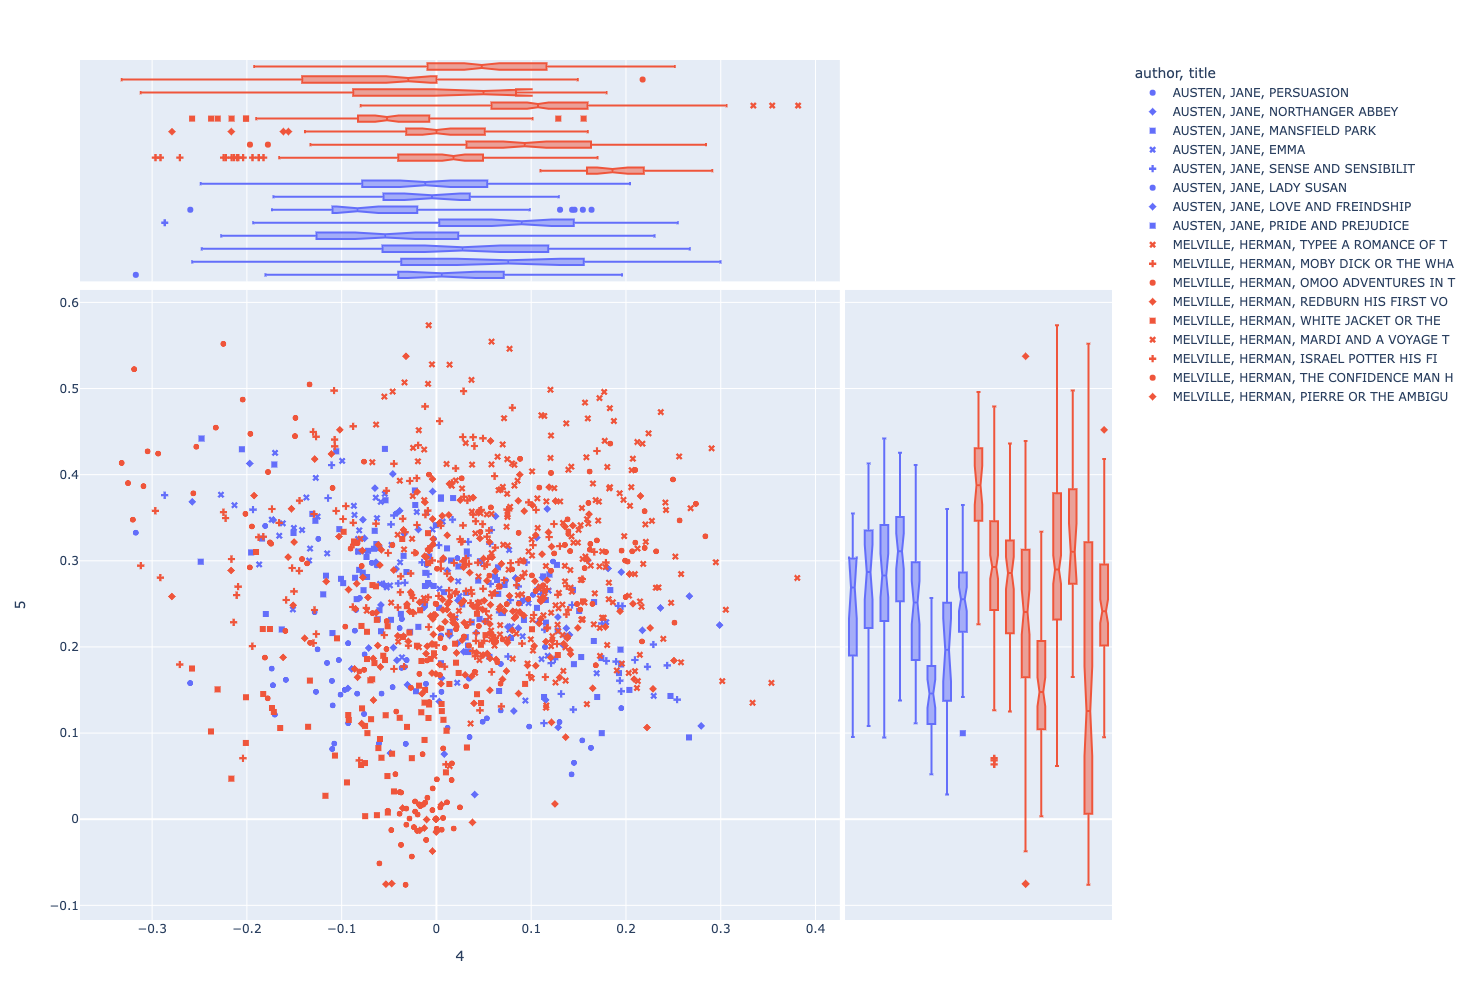

In [45]:
px.scatter(DOC, 4, 5, 
           color='author', symbol='title', 
           hover_name='label', 
           marginal_x='box', marginal_y='box', 
           height=1000)

# Loadings Scatterplots

In [46]:
try:
    VOCAB2 = VOCAB.join(L, how='right').reset_index()
except:
    pass

In [47]:
# VOCAB2

## PC 0 and 1

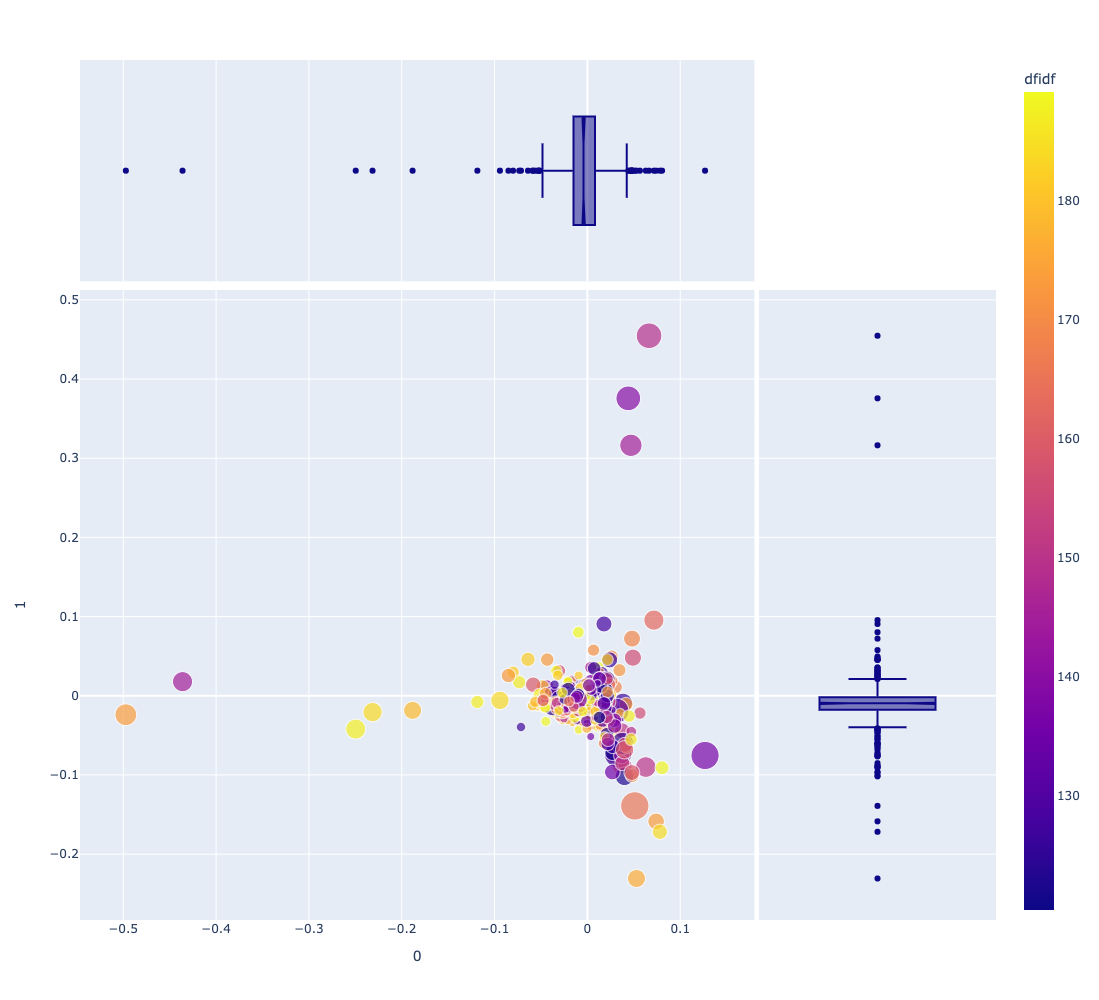

In [48]:
px.scatter(VOCAB2, 0, 1, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', 
           hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

## PC 2 and 3

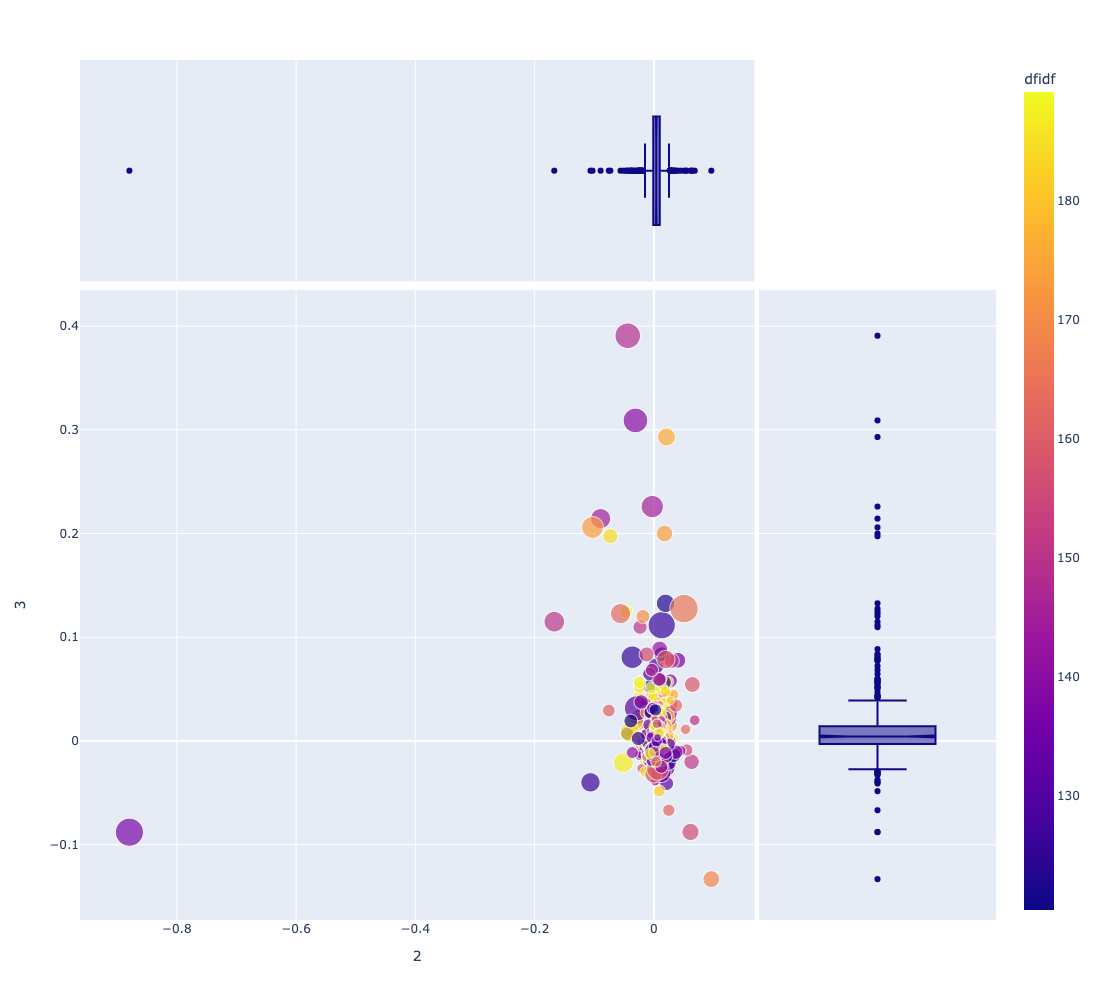

In [49]:
px.scatter(VOCAB2, 2, 3, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

## PC 4 and 5 

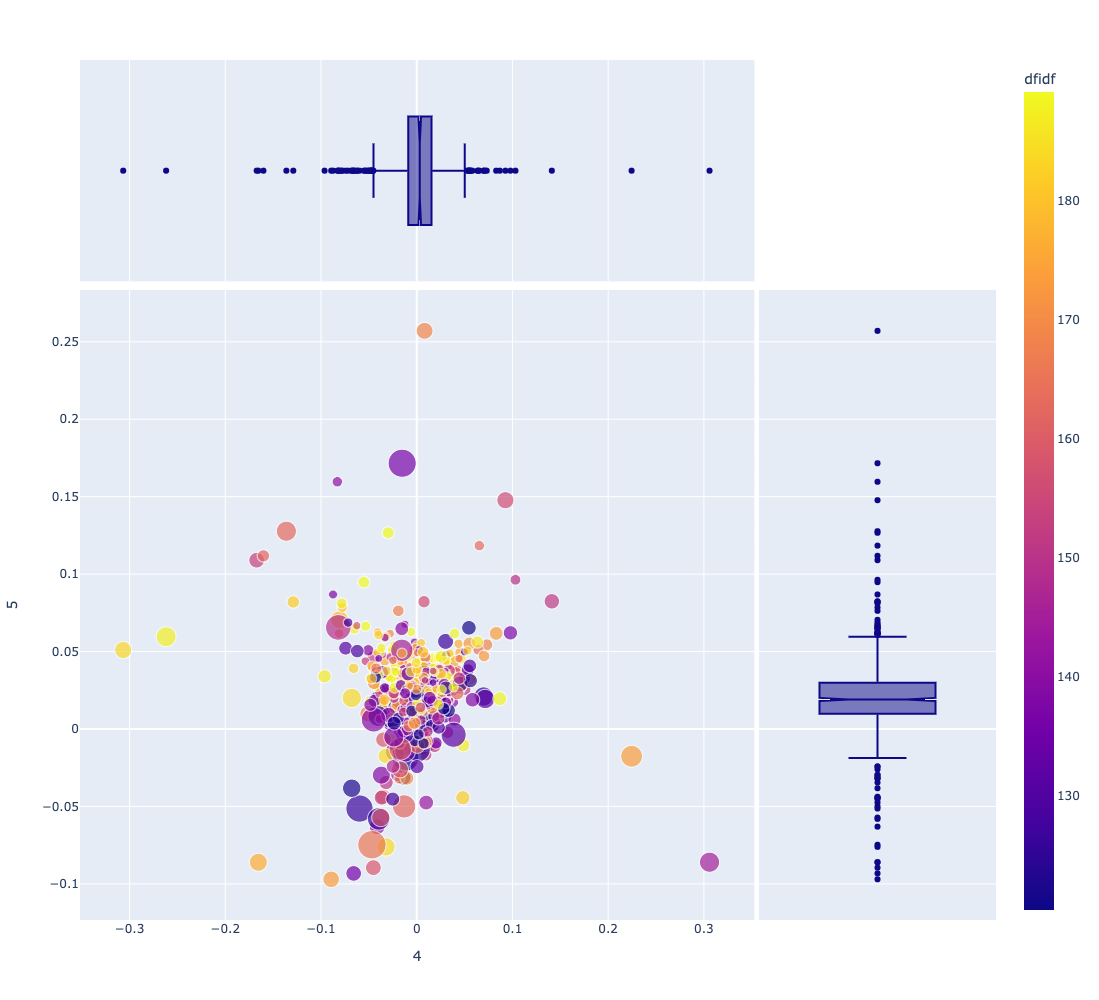

In [50]:
px.scatter(VOCAB2, 4, 5, 
           size='tfidf_mean', color='dfidf', 
           hover_name='term_str', hover_data=['max_pos'], 
           marginal_x='box', marginal_y='box', 
           height=1000, width=1000)

# Components by Books

In [51]:
import sys; sys.path.append(local_lib)
from hac2 import HAC

In [52]:
# try:
#     LIB = LIB.join(DCM.groupby('book_id').mean())
# except:
#     pass

In [53]:
BCM = DCM.groupby('book_id').mean().sort_index()
BCM.index = LIB.loc[list(BCM.index)].label

In [54]:
BCM.sort_values(0, ascending=False).style.background_gradient(cmap='GnBu', high=.5, axis=0)

In [55]:
C[['neg','pos']]

neg                                     pos
pc_id                                                                       
0        whale sea ship deck ye thou             she her mr mrs miss herself
1            thou thee thy ye art oh    captain ship deck sailors mate ships
2       lord our war island king old            whale boat fish she her line
3      thou thee captain thy her she  lord whale king your nature confidence
4      her she island our trees king             sir mr dont captain your ye
5      lord whale said king ye cried      deck officers war captain her lady

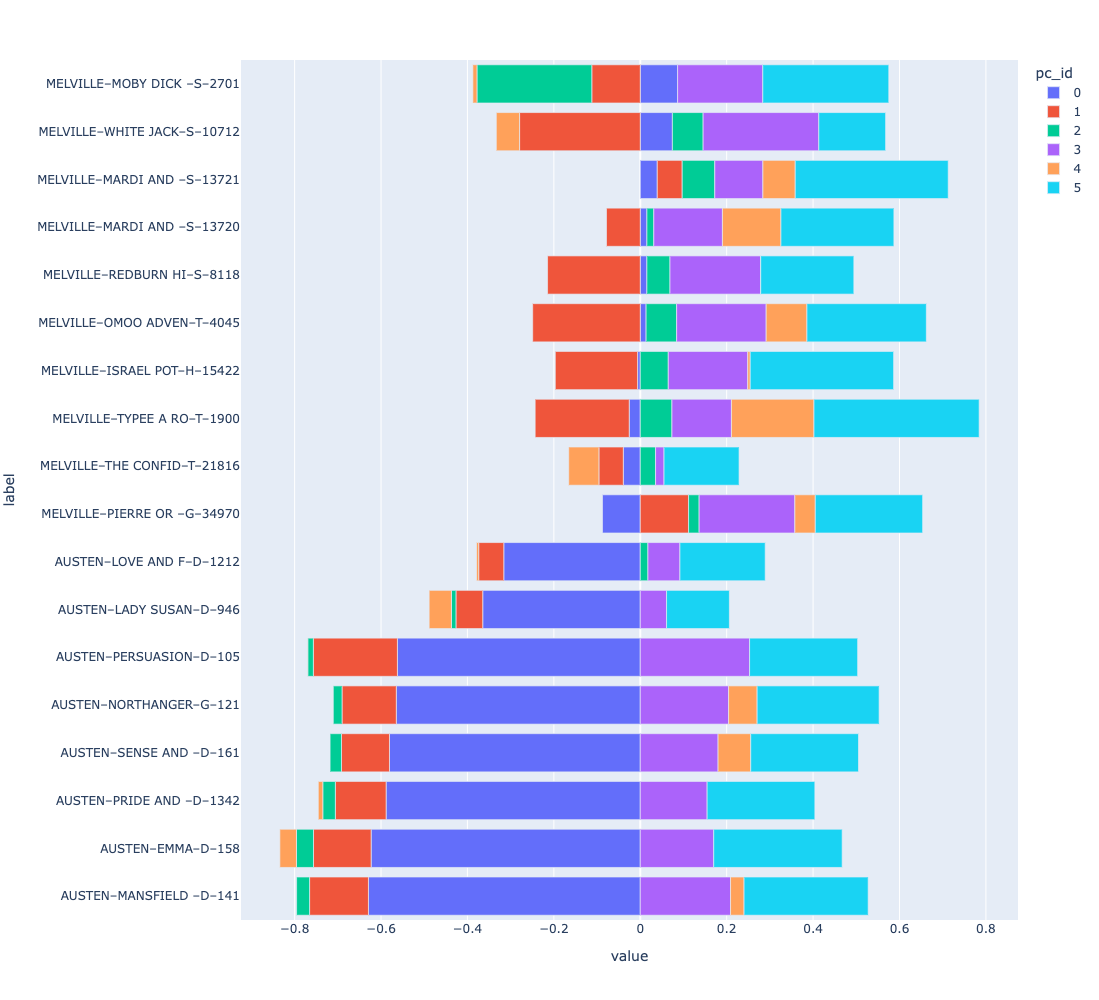

In [56]:
px.bar(BCM.sort_values(0), height=1000, orientation='h', barmode='relative')

In [57]:
print(C.loc[1, ['pos','neg']].values)

['captain ship deck sailors mate ships' 'thou thee thy ye art oh']


## What's up with PC01?

**Pierre**
> Upon its publication in 1851, Herman Melville’s Pierre was criticized as a disaster, a formless “Kraken” composed by a writer obviously deprived of his skills and sanity. Since then, however, scholars have reconsidered the historical context in which the novel was conceived and composed. As a result, Pierre has been redeemed, now regarded by many to be among Melville’s masterpieces. However, little attention has been paid to the Bohemian themes essential to the novel, Bohemian themes that prefigure any treatment of Bohemia in American literature.\
Pierre’s residence in the **“Church of the Apostles,”** where he moves to write his masterpiece, provides Melville with an opportunity to describe a Bohemian commune, replete with painters, communists, convicts, musicians, and other failed artists, as well as comment on the print culture conventions in mid-century America that impact the development of Bohemianism. Edgar Allen Poe is considered by many scholars to be the first American Bohemian and his influence upon both the character of Pierre and the plot and themes of the novel are numerous. Pierre, therefore, foresees Poe’s Bohemian style as a nascent cultural movement fully developed by the 1860s in the figures of Walt Whitman and the patrons of Pfaff’s Saloon.\
&mdash; From James McAdams, 2015/16, "Melville's Pierre and the 'Church of the Bohemians'". _Connotations_, 25:1.\
https://www.connotations.de/article/james-mcadams-melvilles-pierre-and-the-church-of-the-bohemians/

**Mardi**
> Giordano Lahaderne has proposed that Mardi may have in part been **influenced by the Book of Mormon (1830)**. The opening sequence of each is **an "Old Testament in reverse"** and Mardi's second volume includes a discourse on "an illustrious prophet, and teacher divine" named Alma, a name shared by Alma, one of the major prophets and missionaries within the Book of Mormon.[8]\
&mdash; From Wikipedia.



## Components by Authors

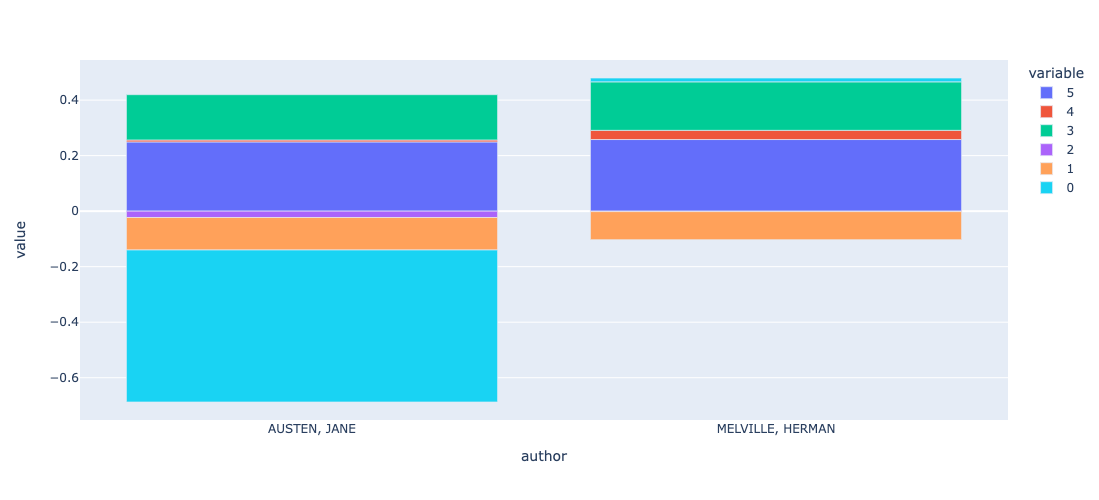

In [58]:
px.bar(DOC.groupby('author')[pc_ids].mean(), width=400, height=500)

## Components by Genre

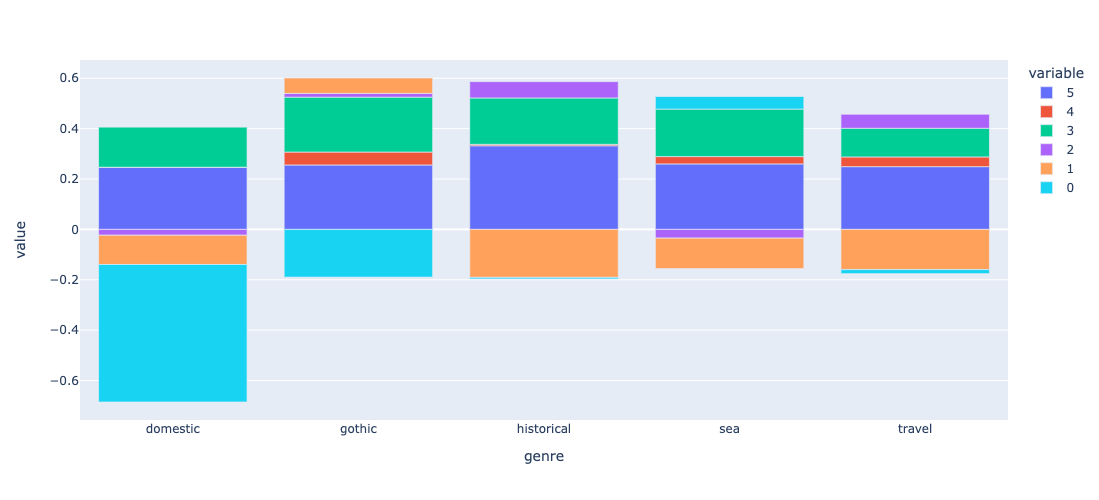

In [59]:
px.bar(DOC.groupby('genre')[pc_ids].mean(), width=800, height=500)

## Dendrograms

In [60]:
import sys; sys.path.append(local_lib)
from hac2 import HAC

<Figure size 432x288 with 0 Axes>

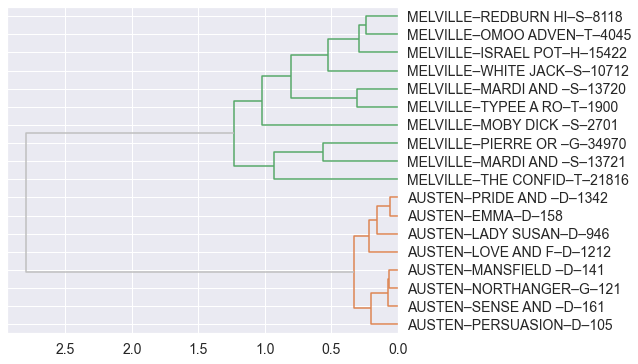

In [61]:
dend1 = HAC(BCM)
dend1.w = 7
dend1.color_thresh = 2.5
dend1.plot()

<Figure size 432x288 with 0 Axes>

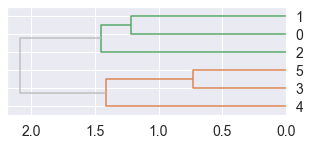

In [62]:
dend2 = HAC(DCM.T)
dend2.w = 5
dend2.color_thresh = 2
dend2.plot()